In [1]:
import math
from typing import Dict, List, Tuple
import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import torch
from tqdm import tqdm
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from unet import UNet, UNet2
from data import musdbDataset
from splitter import Splitter

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [10]:
# Load Test Audio
wav_, _ = librosa.load(
    "/home/ytang363/7100_spr2023/audio/Im Alright Mixture.wav",
    mono=False,
    res_type="kaiser_fast",
    sr=44100,
    duration=15,
    offset=0,
)
wav_vocals_, _ = librosa.load(
    "/home/ytang363/7100_spr2023/audio/Im Alright Vocals.wav",
    mono=False,
    res_type="kaiser_fast",
    sr=44100,
    duration=15,
    offset=0,
)

wav = torch.Tensor(wav_).to("cuda")
wav_vocals = torch.Tensor(wav_vocals_).to("cuda")

funct = Splitter(stem_names=["vocals"])
stft, stft_mag, stft_phase = funct.compute_stft(wav)
stft_vocals, stft_vocals_mag, stft_phase = funct.compute_stft(wav_vocals)
print(wav_.shape)
# ipd.Audio(wav_, rate=44100)

(2, 661500)


In [11]:
# Load weights
model = Splitter(stem_names=["vocals","accompaniment"])
state_dict = torch.load("/home/ytang363/7100_spr2023/model/20230325-16_ep-1000_b-16.pt") # /home/ytang363/7100_spr2023/model/20230315-14_ep-1000_b-4.pt
model.load_state_dict(state_dict["model_state_dict"])
predict = model(wav) # 1 x 2 x L x F
print(predict['vocals'].size())

torch.Size([2, 2, 512, 1024])


In [12]:
def apply_mask(predict, stft, stft_mag, stft_phase):
    '''
    predict shape: 1 x 2 x L x F
    stft_input shape: 2 x F x L x 2
    '''
    mask_sum = sum([m**2 for m in predict.values()])
    mask_sum += 1e-10

    mask = (predict['vocals']**2 + 1e-10 / 2) / (mask_sum)
    mask = mask.transpose(2, 3)
    print("original mask shape:", mask.size())

    mask = torch.cat(torch.split(mask, 1, dim=0), dim=3)
    # mask = mask.squeeze(0)[:, :, :stft.size(2)].unsqueeze(-1) # 2 x F x L x 1
    mask = mask.squeeze(0)[:, :, :stft.size(2)]
    print("transfromed mask shape:", mask.size())

    # Plot masked instrumental
    print("stft mix shape:", stft.size())
    stft_masked_ori = stft * mask.unsqueeze(-1) # original

    print("stft_mag shape:", stft_mag.size())
    src_magnitude = stft_mag * mask
    print("src_magnitude shape:", src_magnitude.size())

    print("stft_phase shape:", stft_phase.size())
    stft_masked = src_magnitude * torch.exp(1j * stft_phase)
    print()

    print("original stft_mask output shape:", stft_masked_ori.size())
    print("new stft_mask output shape:", stft_masked.size())
    return stft_masked, stft_masked_ori
    # return stft_masked_ori, stft_masked_ori.cpu().detach().numpy()[0][:, :, 0]

In [13]:
stft_masked, stft_masked_ori = apply_mask(predict, stft, stft_mag, stft_phase)

original mask shape: torch.Size([2, 2, 1024, 512])
transfromed mask shape: torch.Size([2, 1024, 646])
stft mix shape: torch.Size([2, 1024, 646, 2])
stft_mag shape: torch.Size([2, 1024, 646])
src_magnitude shape: torch.Size([2, 1024, 646])
stft_phase shape: torch.Size([2, 1024, 646])

original stft_mask output shape: torch.Size([2, 1024, 646, 2])
new stft_mask output shape: torch.Size([2, 1024, 646])


torch.Size([1024, 646])
torch.Size([1024, 646])


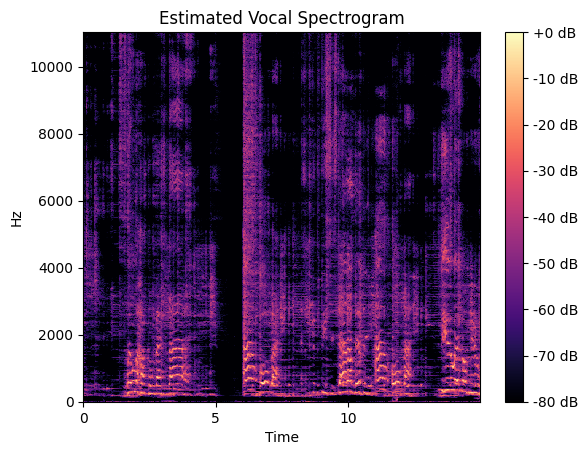

In [16]:
### Display Mask ###
new = stft_masked.cpu().detach()[0]
original = stft_masked_ori.cpu().detach()[0][:,:,0]
print(original.size())
print(new.size())

S_db = librosa.amplitude_to_db(np.abs(new), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Estimated Vocal Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [15]:
def inverse_stft(stft: Tensor) -> Tensor:
    """Inverses stft to wave form"""

    pad = 4096 // 2 + 1 - stft.size(1) # 4096 // 2 + 1 - 1024 = 1025
    print(stft.size())
    # stft = F.pad(stft, (0, 0, 0, 0, 0, pad)) # 2 x 2049 x 431 x 2
    stft = F.pad(stft, (0, 0, 0, pad))
    print(stft.size()) 

    wav = torch.istft(
        stft,
        4096,
        hop_length=1024,
        center=True,
        window=nn.Parameter(torch.hann_window(4096), requires_grad=False).to("cuda"),
    )
    return wav.detach()

output = inverse_stft(stft_masked)
output_mono = torch.mean(output, dim=0, keepdim=True)
output = output.cpu().detach().numpy()
print(output.shape)
ipd.Audio(output, rate=44100)

torch.Size([2, 1024, 646])
torch.Size([2, 2049, 646])
(2, 660480)


torch.Size([1, 128, 431])


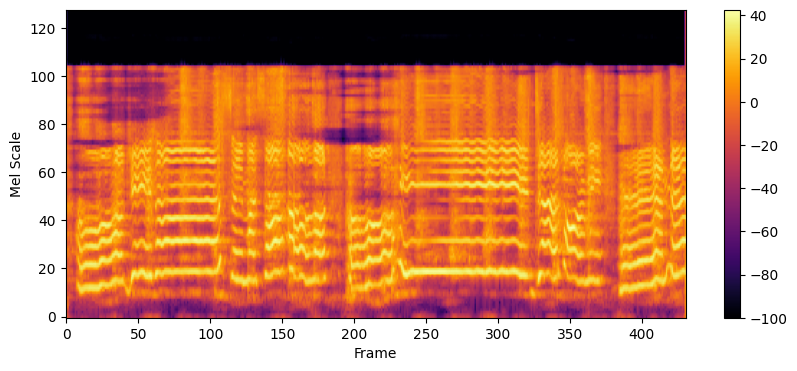

In [8]:
import torchaudio.transforms as transforms
output.size()
mel_spectrogram = transforms.MelSpectrogram(sample_rate=44100, n_fft=2048, hop_length=1024, n_mels=128).to("cuda")
mel_spec = mel_spectrogram(output_mono).to('cpu')

# Convert mel spectrogram to decibels
mel_spec_db = transforms.AmplitudeToDB()(mel_spec)
mel_spec_db = mel_spec_db.squeeze(0)
print(mel_spec.size())

# mel_spec = mel_spec.cpu().detach().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db, cmap='inferno', aspect='auto', origin='lower')
plt.xlabel('Frame')
plt.ylabel('Mel Scale')
plt.colorbar()
plt.show()

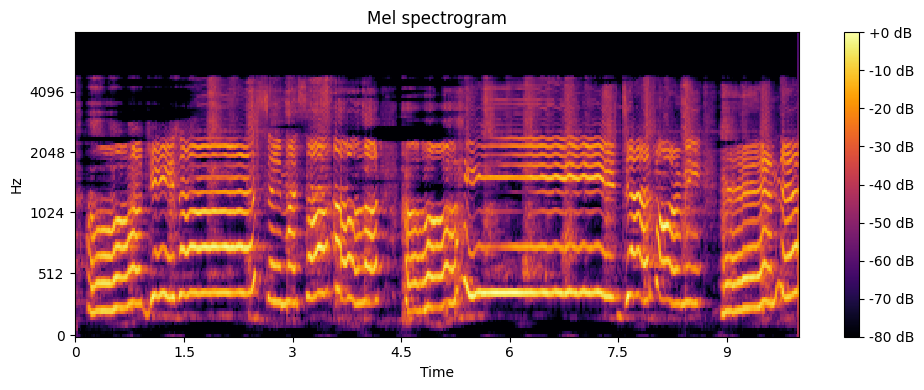

In [9]:
# Compute mel spectrogram
n_fft = 2048
hop_length = 1024
n_mels = 128
sr = 44100
output_ = output_mono.cpu().detach().numpy()
S = librosa.feature.melspectrogram(y=output_, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Convert power spectrogram to dB scale
S_db = librosa.power_to_db(S, ref=np.max)

# Display mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db[0], x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length, cmap='inferno', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [10]:
def compute_stft(wav: Tensor) -> Tuple[Tensor, Tensor]:
    """
    Computes stft feature from wav
    Args:
        wav (Tensor): B x L
    """
    stft = torch.stft(
        wav,
        n_fft=4096,
        hop_length=1024,
        window=nn.Parameter(torch.hann_window(4096), requires_grad=False).to("cuda"),
        center=True,
        return_complex=False,
        pad_mode="reflect",
    )

    # only keep freqs smaller than self.F
    stft = stft[:, 0:1024, :, :]
    real = stft[:, :, :, 0]
    im = stft[:, :, :, 1]
    mag = torch.sqrt(real**2 + im**2)
    phase = torch.atan2(im, real)
    return stft, mag, phase

estimated_stft = stft_masked
print("estimated_stft mag size:", estimated_stft.size())
target_stft, target_mag, target_phase = compute_stft(wav_vocals)
print("target_mag size:", target_mag.size())

loss = torch.nn.functional.mse_loss(torch.abs(estimated_stft), target_mag)
print(loss)

print()
print(torch.abs(estimated_stft).size())
print(target_mag)

estimated_stft mag size: torch.Size([2, 1024, 431])
target_mag size: torch.Size([2, 1024, 431])
tensor(1.6153, device='cuda:0', grad_fn=<MseLossBackward0>)

torch.Size([2, 1024, 431])
tensor([[[0.6111, 0.4733, 0.3075,  ..., 1.8111, 2.6716, 6.4474],
         [0.4189, 0.2407, 0.1458,  ..., 0.5587, 1.2755, 4.4949],
         [0.1927, 0.0874, 0.0204,  ..., 0.4956, 0.4948, 3.5644],
         ...,
         [0.4920, 0.4584, 0.2866,  ..., 0.0785, 0.0714, 0.0477],
         [0.0751, 0.3369, 0.1194,  ..., 0.0652, 0.0363, 0.0267],
         [0.4698, 0.3011, 0.1141,  ..., 0.0508, 0.0586, 0.0360]],

        [[0.5237, 0.4496, 0.3324,  ..., 1.5136, 2.3781, 6.1759],
         [0.3608, 0.1892, 0.1938,  ..., 0.3299, 1.2207, 4.3813],
         [0.2224, 0.1325, 0.0515,  ..., 0.6754, 0.6843, 3.7819],
         ...,
         [0.4904, 0.4573, 0.2863,  ..., 0.0789, 0.0720, 0.0504],
         [0.0737, 0.3365, 0.1195,  ..., 0.0652, 0.0365, 0.0285],
         [0.4706, 0.3014, 0.1137,  ..., 0.0506, 0.0588, 0.0351]]],
    

In [11]:
from util import utility
util = utility()
target_mel, target_mel_db = util.mel_spec(wav_vocals, time_domain=True)
est_mel, est_mel_db = util.mel_spec(stft_masked, time_domain=False)
loss_mel = torch.nn.functional.mse_loss(est_mel, target_mel)
mae_loss = nn.L1Loss()
loss = mae_loss(est_mel, target_mel)
# loss = loss_mel

In [12]:
loss

tensor(0.2253, grad_fn=<MeanBackward0>)

In [13]:
loss

tensor(0.2253, grad_fn=<MeanBackward0>)